In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install prophet
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import optuna

In [4]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/CMG.csv')
# Chuyển đổi cột thời gian thành định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])
# Tạo DataFrame dữ liệu đầu vào
df = pd.DataFrame({'ds': data['Date'], 'y': data['Price']})
df

,ds,y
0,2017-12-01,19753
1,2017-12-04,20612
2,2017-12-05,21008
3,2017-12-06,22065
4,2017-12-07,23585
...,...,...
1371,2023-06-05,44050
1372,2023-06-06,45700
1373,2023-06-07,45500
1374,2023-06-08,44500


In [5]:
# Chia tập dữ liệu thành train-test-validate theo tỉ lệ
n = len(df)
n_train = int(n * 0.7)
n_test = int(n * 0.2)
n_validate = n - n_train - n_test

train_data = df[:n_train]
test_data = df[n_train:n_train + n_test]
validate_data = df[n_train + n_test:]

In [6]:
# Hàm mục tiêu để tối ưu hóa
def objective(trial):
    # Xác định không gian tìm kiếm cho siêu tham số
    params = {
        'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
        'seasonality_prior_scale': trial.suggest_loguniform('seasonality_prior_scale', 0.01, 1.0),
        'holidays_prior_scale': trial.suggest_loguniform('holidays_prior_scale', 0.01, 10.0),
    }

    # Xây dựng mô hình BSTS với siêu tham số hiện tại
    model = Prophet(**params)
    model.fit(train_data)

    # Dự đoán trên tập test
    forecast = model.predict(test_data)

    # Tính toán độ đo RMSE để đánh giá mô hình
    rmse = mean_squared_error(test_data['y'], forecast['yhat'], squared=False)

    return rmse

In [7]:
# Tìm giá trị tối ưu cho siêu tham số
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=350)

# Lấy giá trị tối ưu cho siêu tham số
best_params = study.best_params

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] done processing
[I 2023-06-18 16:32:04,008] Trial 55 finished with value: 9454.30848460616 and parameters: {'changepoint_prior_scale': 0.01750239215364029, 'seasonality_prior_scale': 0.12232158986465615, 'holidays_prior_scale': 3.1715815801806926}. Best is trial 54 with value: 9344.617931634046.
<ipython-input-6-bb80d6b1eb20>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'changepoint_prior_scale': trial.suggest_loguniform('changepoint_prior_scale', 0.01, 10.0),
<ipython-input-6-bb80d6b1eb20>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'seasonality_prior_scale': trial.suggest_loguniform('

In [8]:
# Xây dựng mô hình BSTS với siêu tham số tốt nhất
best_model = Prophet(**best_params)
best_model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdsgc936/9_08xa9o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptdsgc936/4pqzhfma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70510', 'data', 'file=/tmp/tmptdsgc936/9_08xa9o.json', 'init=/tmp/tmptdsgc936/4pqzhfma.json', 'output', 'file=/tmp/tmptdsgc936/prophet_modelvh_kxgnd/prophet_model-20230618163504.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:35:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
print("Siêu tham số tối ưu:", best_params)

Siêu tham số tối ưu: {'changepoint_prior_scale': 0.012087088139174694, 'seasonality_prior_scale': 0.3268019855848048, 'holidays_prior_scale': 1.455156849520637}


In [10]:
# Dự đoán trên tập test và validate
test_forecast = best_model.predict(test_data)
validate_forecast = best_model.predict(validate_data)

In [11]:
# Dự đoán 30 ngày tiếp theo
future_dates = pd.date_range(start=df['ds'].max(), periods=30, freq='D')
future_data = pd.DataFrame({'ds': future_dates})

future_forecast = best_model.predict(future_data)

In [12]:
# In kết quả dự đoán
future_forecast['yhat']

0     62588.134171
1     61649.502653
2     61717.081597
3     62805.375262
4     62904.751489
5     62903.388174
6     62974.768238
7     63047.605764
8     62100.748317
9     62157.297679
10    63231.922352
11    63315.246642
12    63295.788457
13    63347.443083
14    63399.396051
15    62431.010583
16    62465.932386
17    63519.385691
18    63582.545897
19    63544.461497
20    63579.523054
21    63617.362772
22    62637.730577
23    62664.589765
24    63713.406362
25    63775.517701
26    63740.052945
27    63781.403273
28    63829.125172
29    62862.822515
Name: yhat, dtype: float64

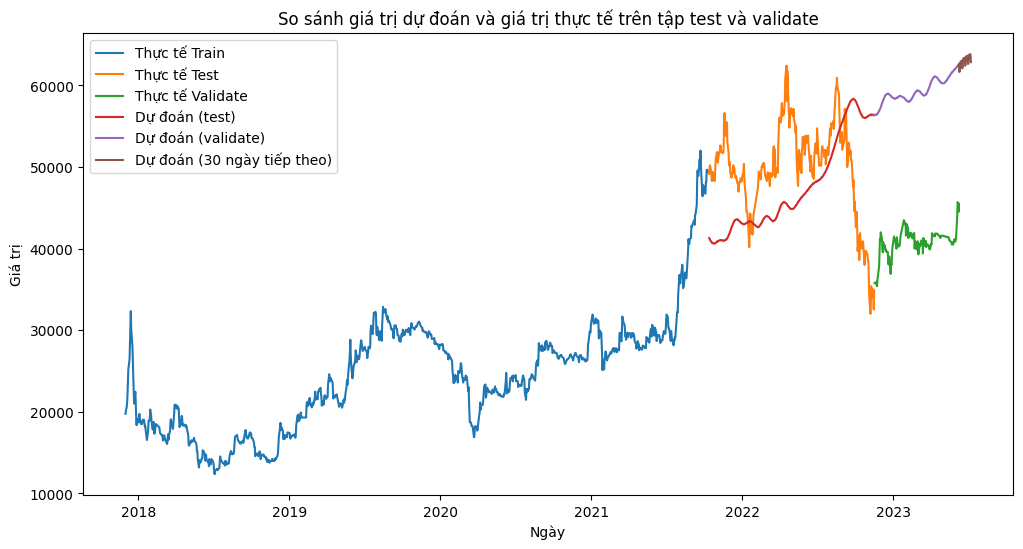

In [13]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(train_data['ds'], train_data['y'], label='Thực tế Train')
plt.plot(test_data['ds'], test_data['y'], label='Thực tế Test')
plt.plot(validate_data['ds'], validate_data['y'], label='Thực tế Validate')
plt.plot(test_data['ds'], test_forecast['yhat'], label='Dự đoán (test)')
plt.plot(validate_data['ds'], validate_forecast['yhat'], label='Dự đoán (validate)')
plt.plot(future_dates, future_forecast['yhat'], label='Dự đoán (30 ngày tiếp theo)')
plt.xlabel('Ngày')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và giá trị thực tế trên tập test và validate')
plt.legend()
plt.show()

In [14]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho test data
rmse = np.sqrt(mean_squared_error(test_data['y'], test_forecast['yhat']))
mape = mean_absolute_percentage_error(test_data['y'], test_forecast['yhat'])*100
mse = mean_squared_error(test_data['y'], test_forecast['yhat'])
mae = mean_absolute_error(test_data['y'], test_forecast['yhat'])
r2 = r2_score(test_data['y'], test_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 9326.545877118959
MAPE: 16.341234952550195
MSE: 86984457.99800465
MAE: 7701.0606149654905
R2: -1.7091789335025718


In [15]:
# Tính toán độ đo RMSE, MAPE, MSE, MAE và R2 cho validate data
rmse = np.sqrt(mean_squared_error(validate_data['y'], validate_forecast['yhat']))
mape = mean_absolute_percentage_error(validate_data['y'], validate_forecast['yhat'])*100
mse = mean_squared_error(validate_data['y'], validate_forecast['yhat'])
mae = mean_absolute_error(validate_data['y'], validate_forecast['yhat'])
r2 = r2_score(validate_data['y'], validate_forecast['yhat'])

print("RMSE:", rmse)
print("MAPE:", mape)
print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 18716.231882776097
MAPE: 45.97105714581487
MSE: 350297335.8898445
MAE: 18654.183587594685
R2: -118.86606901930357
